In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from functools import reduce

In [2]:
def read_cred():
    f = open("../../../cred.txt", "r")
    cred = f.read()
    f.close()
    return cred

In [3]:
def get_OI(url,start,end,interval='PT1M',tag='xx',auth='xx',hS='00',hF='23'):
	url_all =url+'data-reference='+tag+'&aggregation=TIME'+'&aggregation-function=MEAN'+"&from="+start+"T"+hS+"%3A00%3A00.000Z&to="+end+"T"+hF+"%3A59%3A59.000Z&aggregation-period="+interval
	d_data = pd.read_json(url_all,storage_options={ 'Authorization': 'basic '+auth})
	# print(d_data['values'][0])
	arr = np.asarray(np.asarray(d_data['values'])[0])
	return d_data['values'][0]

In [4]:
urlBase = 'https://oianalytics-100.optimistik.fr/api/oianalytics/time-values/query?'
credentials = read_cred()

In [29]:
def get_data(tags):
    liste = list(range(0))
    for tag in tags:
        data = get_OI(urlBase,'2021-07-01','2022-02-25','PT20M',tag,credentials,'00','23')
        df = pd.DataFrame(data)
        df['timestamp'] = pd.to_datetime(df['timestamp'])
        df = df.set_index('timestamp')
        df = df.rename(columns={'value':tag})
        liste.append(df)
    return liste

In [6]:
def merge_data(liste):
    df = reduce(lambda left,right : pd.merge(left, right,left_index=True,right_index=True,how='outer'),liste)
    return df

In [30]:
tags = ['E-T15223','E-T18223','3B-T99994','E-FC16325','E-FCS14325','E-FCS12085','E-FS31053','E-FC33005','E-FQ41504','E-QUR-E2']
#tags = ['E-T15223','E-T18223','E-FCS14325','E-FC16325','E-FCS12085','E-LS18603','E-LC18604','E-LS15603','E-LC15604','E-FS31053','E-PD15010','E-PD18010','3B-T99994','E-QUR-E2','ROC_E2_Prod_MMP_brut','E-FQ41504','E-TC18202','E-TC15202']
df_list = get_data(tags)
data = merge_data(df_list)
result = data.copy()
result.describe()

,E-T15223,E-T18223,3B-T99994,E-FC16325,E-FCS14325,E-FCS12085,E-FS31053,E-FC33005,E-FQ41504,E-QUR-E2
count,17276.000000,17276.000000,17230.000000,17276.000000,17276.000000,17276.000000,17276.000000,17276.000000,17276.000000,1.727600e+04
mean,388.062927,381.668927,13.803077,8046.073474,4253.210891,45450.564728,9891.696710,123471.054867,15918.581622,8.879214e+02
std,22.190385,20.024754,8.303048,2429.710465,1162.007671,12721.405464,2794.352677,20453.778666,4881.492112,3.165900e+05
min,268.276000,247.917750,-3.491465,-0.075176,14.089720,3.949767,12.239705,0.263694,-26.876130,-3.534675e+07
25%,380.206988,378.053288,6.859182,7454.786250,3837.389750,44000.145000,10040.018750,119014.675000,14915.743750,5.162218e+02
50%,395.597250,386.351925,12.793658,9192.638250,4650.063000,50988.247500,10553.337500,131427.125000,18200.717500,5.206696e+02
75%,400.316775,391.458500,20.166286,9586.996875,4776.840500,52498.370000,11079.475000,133454.650000,18990.032500,5.255702e+02
max,423.423450,414.827000,37.633960,10076.175000,7733.611000,52554.240000,12871.715000,136183.400000,22686.530000,1.995554e+07


## Filtre

In [8]:
def filtering(df):
    df = df[(df['E-QUR-E2']>500) & (df['E-QUR-E2']<600)]
    df = df[df['E-T15223']>390]
    df = df[df['E-FC16325']>8400]
    df = df[df['E-FCS12085']>48000]
    return df

In [31]:
result = filtering(result)
result.describe()

,E-T15223,E-T18223,3B-T99994,E-FC16325,E-FCS14325,E-FCS12085,E-FS31053,E-FC33005,E-FQ41504,E-QUR-E2
count,8319.000000,8319.000000,8273.000000,8319.000000,8319.000000,8319.000000,8319.000000,8319.000000,8319.000000,8319.000000
mean,399.661874,389.709486,16.456118,9520.735181,4854.390243,52195.914297,10243.482395,132560.903996,18846.912597,521.796878
std,4.520542,4.979865,8.065998,206.966594,278.894093,796.130524,412.875719,2924.012129,444.236083,6.300953
min,390.021700,379.029900,-1.309197,8405.569000,4010.566500,48000.010000,9058.977500,115705.100000,16206.735000,500.148650
25%,396.551475,386.306800,9.569199,9539.876000,4709.736750,52482.942500,9927.941500,131945.650000,18728.967500,517.861600
50%,399.283500,388.979900,17.465935,9585.050000,4758.561500,52496.850000,10270.435000,132954.050000,18964.945000,521.343000
75%,402.178500,393.136650,22.369920,9612.604500,5127.656750,52507.140000,10543.775000,134995.200000,19115.912500,524.962375
max,423.423450,409.167350,37.633960,10076.175000,5714.991500,52554.240000,11398.895000,136183.400000,19984.880000,561.095900


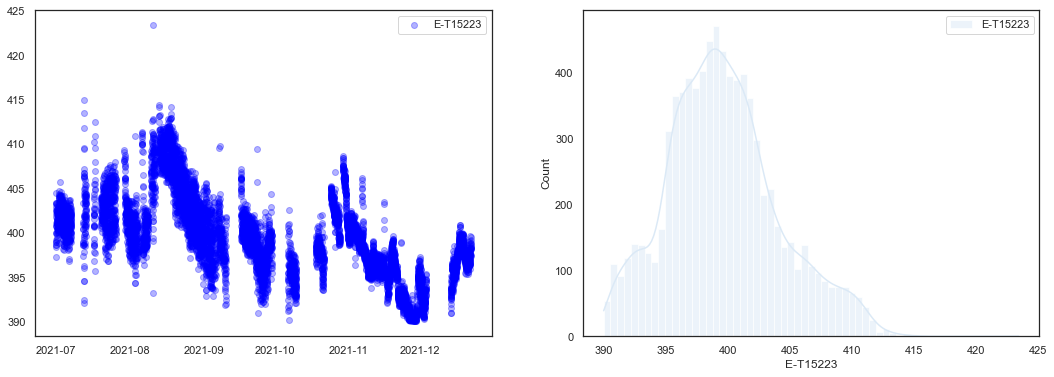

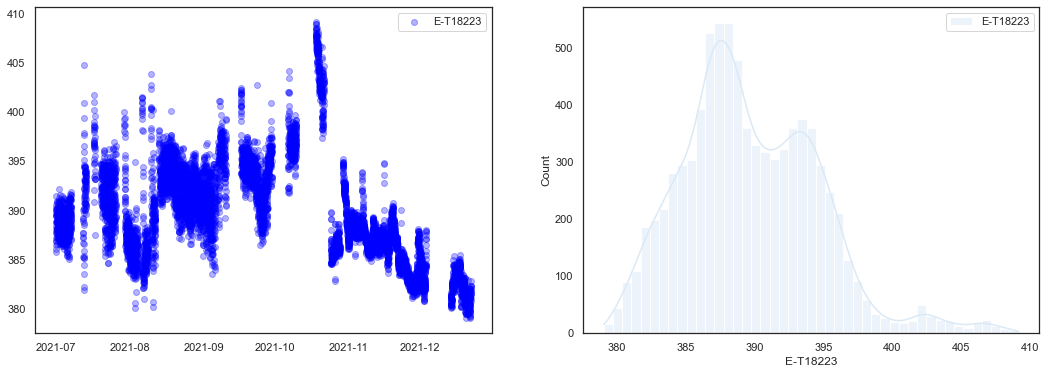

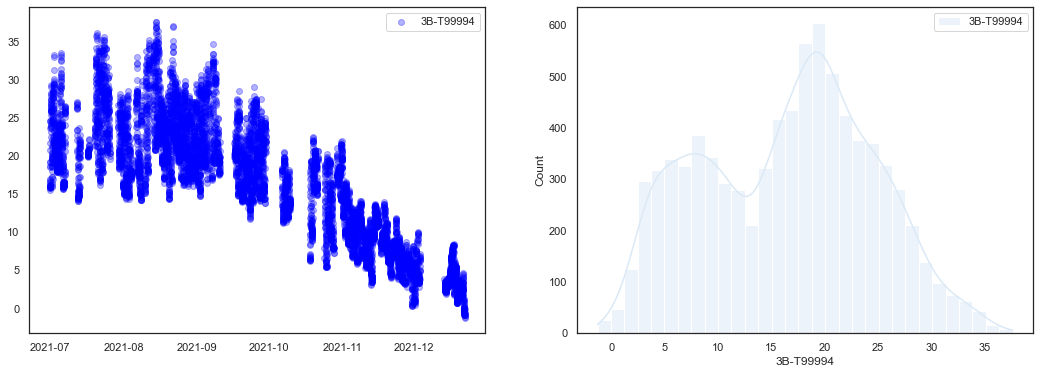

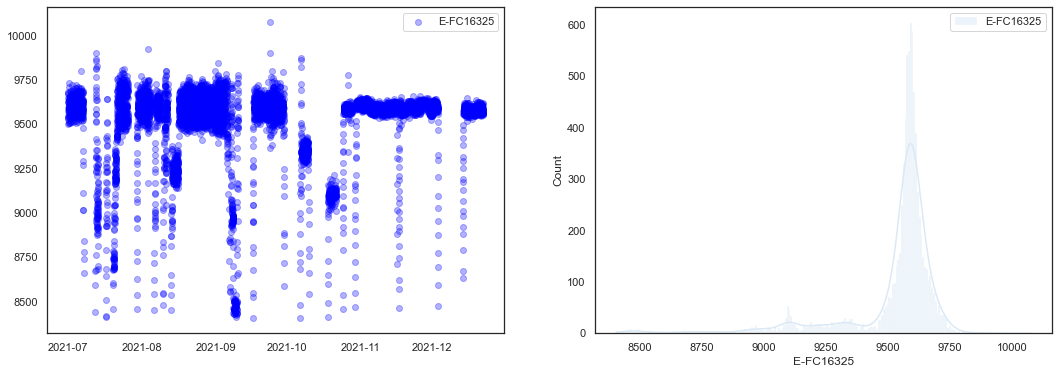

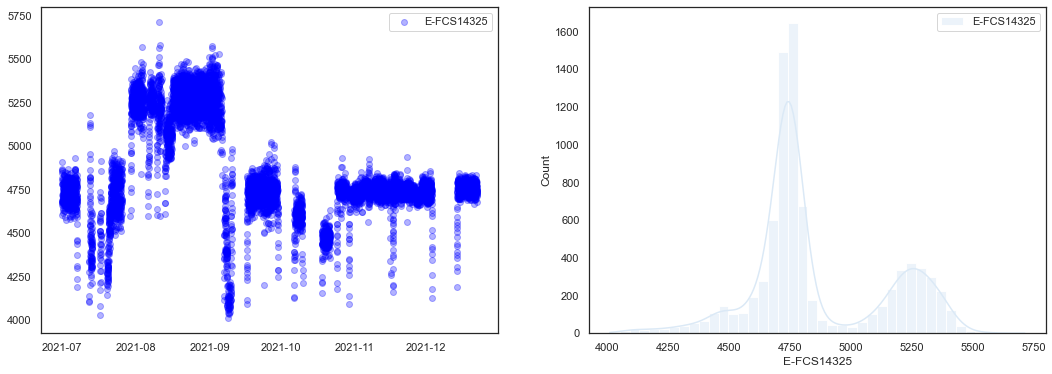

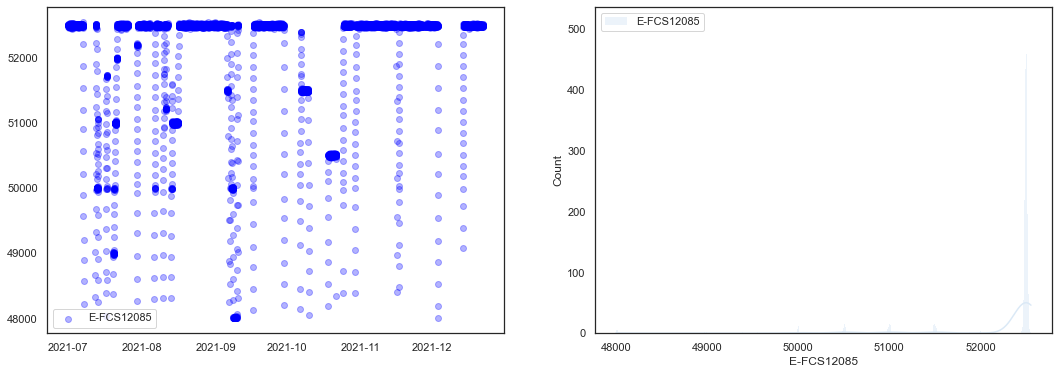

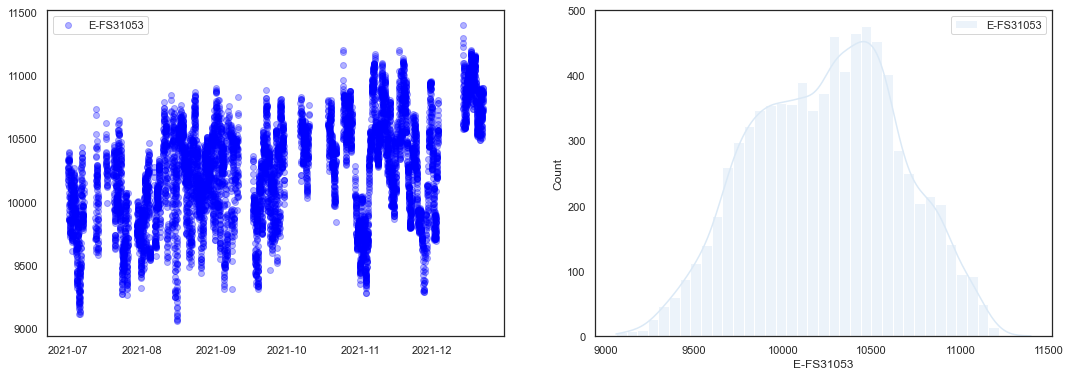

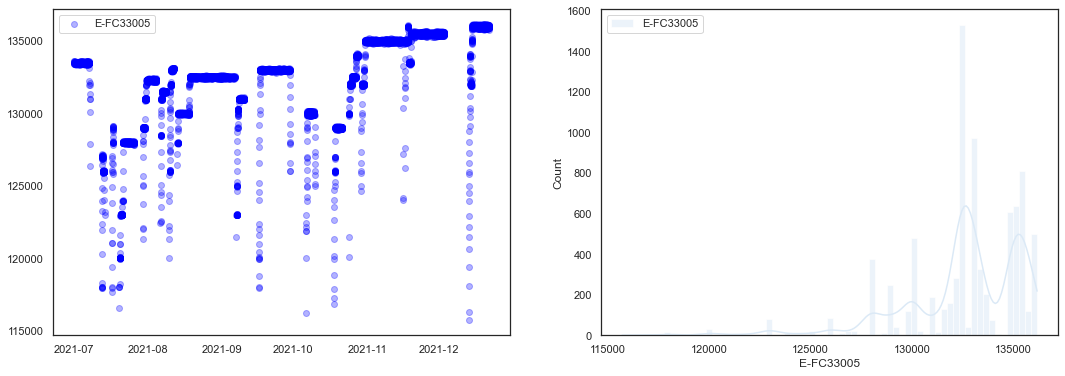

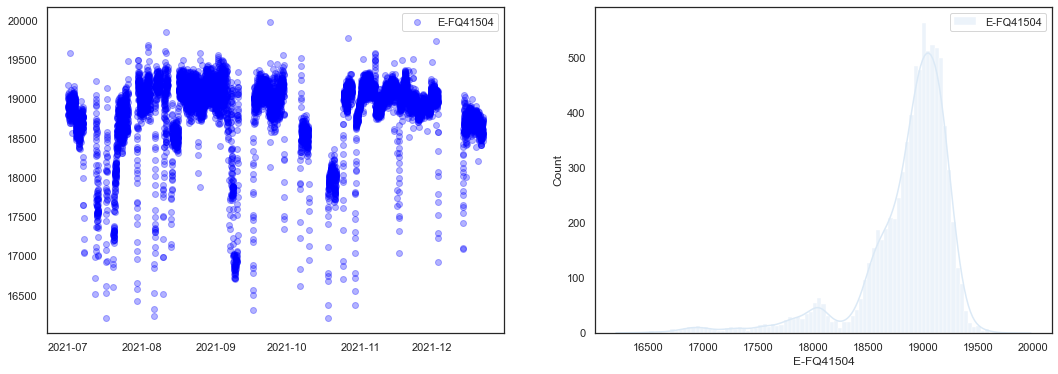

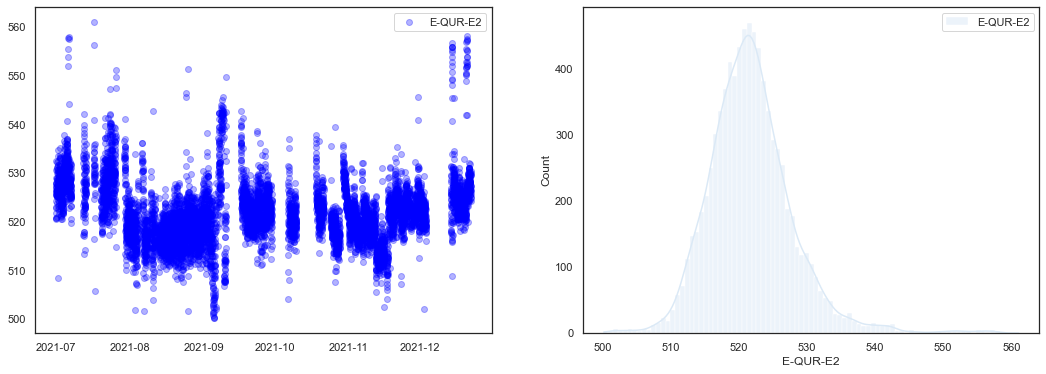

In [32]:
for tag in tags:
    plt.figure(figsize=(18,6))
# plt.plot(result[tags[0]],label=tags[0])
    plt.subplot(121)
    plt.scatter(result.index ,result[tag],label=tag, c='b', alpha=0.3)
    plt.legend()
    plt.subplot(122)
    sns.histplot(result[tag],label=tag,kde=True,common_norm=True)
    plt.legend()

In [11]:
def get_perf(row):
    crit = 'E-QUR-E2'
    if row['E-QUR-E2'] > 540:
        ret=10
    elif row['E-QUR-E2']>535:
        ret=9
    elif row['E-QUR-E2']>530:
        ret=8
    elif row['E-QUR-E2']>525:
        ret=7
    elif row['E-QUR-E2']>520:
        ret=6
    elif row['E-QUR-E2']>515:
        ret=5
    elif row['E-QUR-E2']>510:
        ret=4
    elif row['E-QUR-E2']>505:
        ret=3
    elif row['E-QUR-E2']>500:
        ret=2
    elif row['E-QUR-E2']>495:
        ret=1
    else:
        ret =0
    return ret   

In [33]:
result['perf'] = result.apply(get_perf,axis=1)
result = result.drop('E-QUR-E2',axis=1)
result.describe()

,E-T15223,E-T18223,3B-T99994,E-FC16325,E-FCS14325,E-FCS12085,E-FS31053,E-FC33005,E-FQ41504,perf
count,8319.000000,8319.000000,8273.000000,8319.000000,8319.000000,8319.000000,8319.000000,8319.000000,8319.000000,8319.000000
mean,399.661874,389.709486,16.456118,9520.735181,4854.390243,52195.914297,10243.482395,132560.903996,18846.912597,5.851184
std,4.520542,4.979865,8.065998,206.966594,278.894093,796.130524,412.875719,2924.012129,444.236083,1.239807
min,390.021700,379.029900,-1.309197,8405.569000,4010.566500,48000.010000,9058.977500,115705.100000,16206.735000,2.000000
25%,396.551475,386.306800,9.569199,9539.876000,4709.736750,52482.942500,9927.941500,131945.650000,18728.967500,5.000000
50%,399.283500,388.979900,17.465935,9585.050000,4758.561500,52496.850000,10270.435000,132954.050000,18964.945000,6.000000
75%,402.178500,393.136650,22.369920,9612.604500,5127.656750,52507.140000,10543.775000,134995.200000,19115.912500,6.000000
max,423.423450,409.167350,37.633960,10076.175000,5714.991500,52554.240000,11398.895000,136183.400000,19984.880000,10.000000


<AxesSubplot:ylabel='perf'>

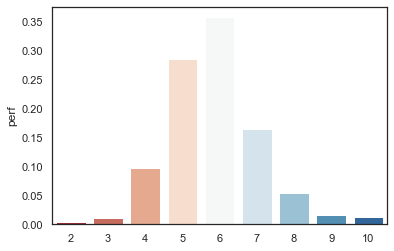

In [34]:
freq = (result.perf.value_counts() / result.shape[0])
df = pd.DataFrame(freq).sort_index()
sns.barplot(data=df, x=df.index,y='perf',palette='RdBu')


<AxesSubplot:xlabel='E-FC16325', ylabel='Count'>

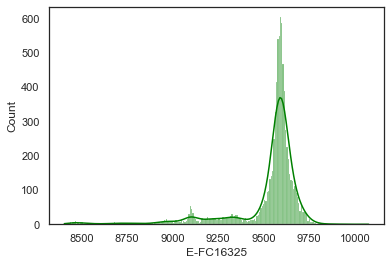

In [35]:
sns.color_palette("tab10")
sns.color_palette("rocket", as_cmap=True)
couleur = ['b','g','r','y','g']
sns.histplot(result['E-FC16325'],kde=True , color='g')

<AxesSubplot:>

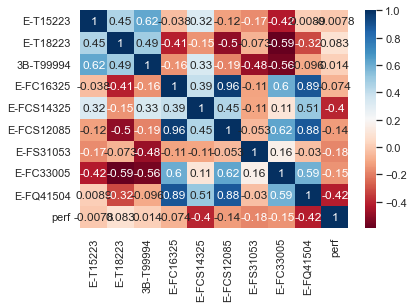

In [36]:
sns.color_palette("tab10")
sns.heatmap(result.corr(),annot=True, cmap='RdBu')

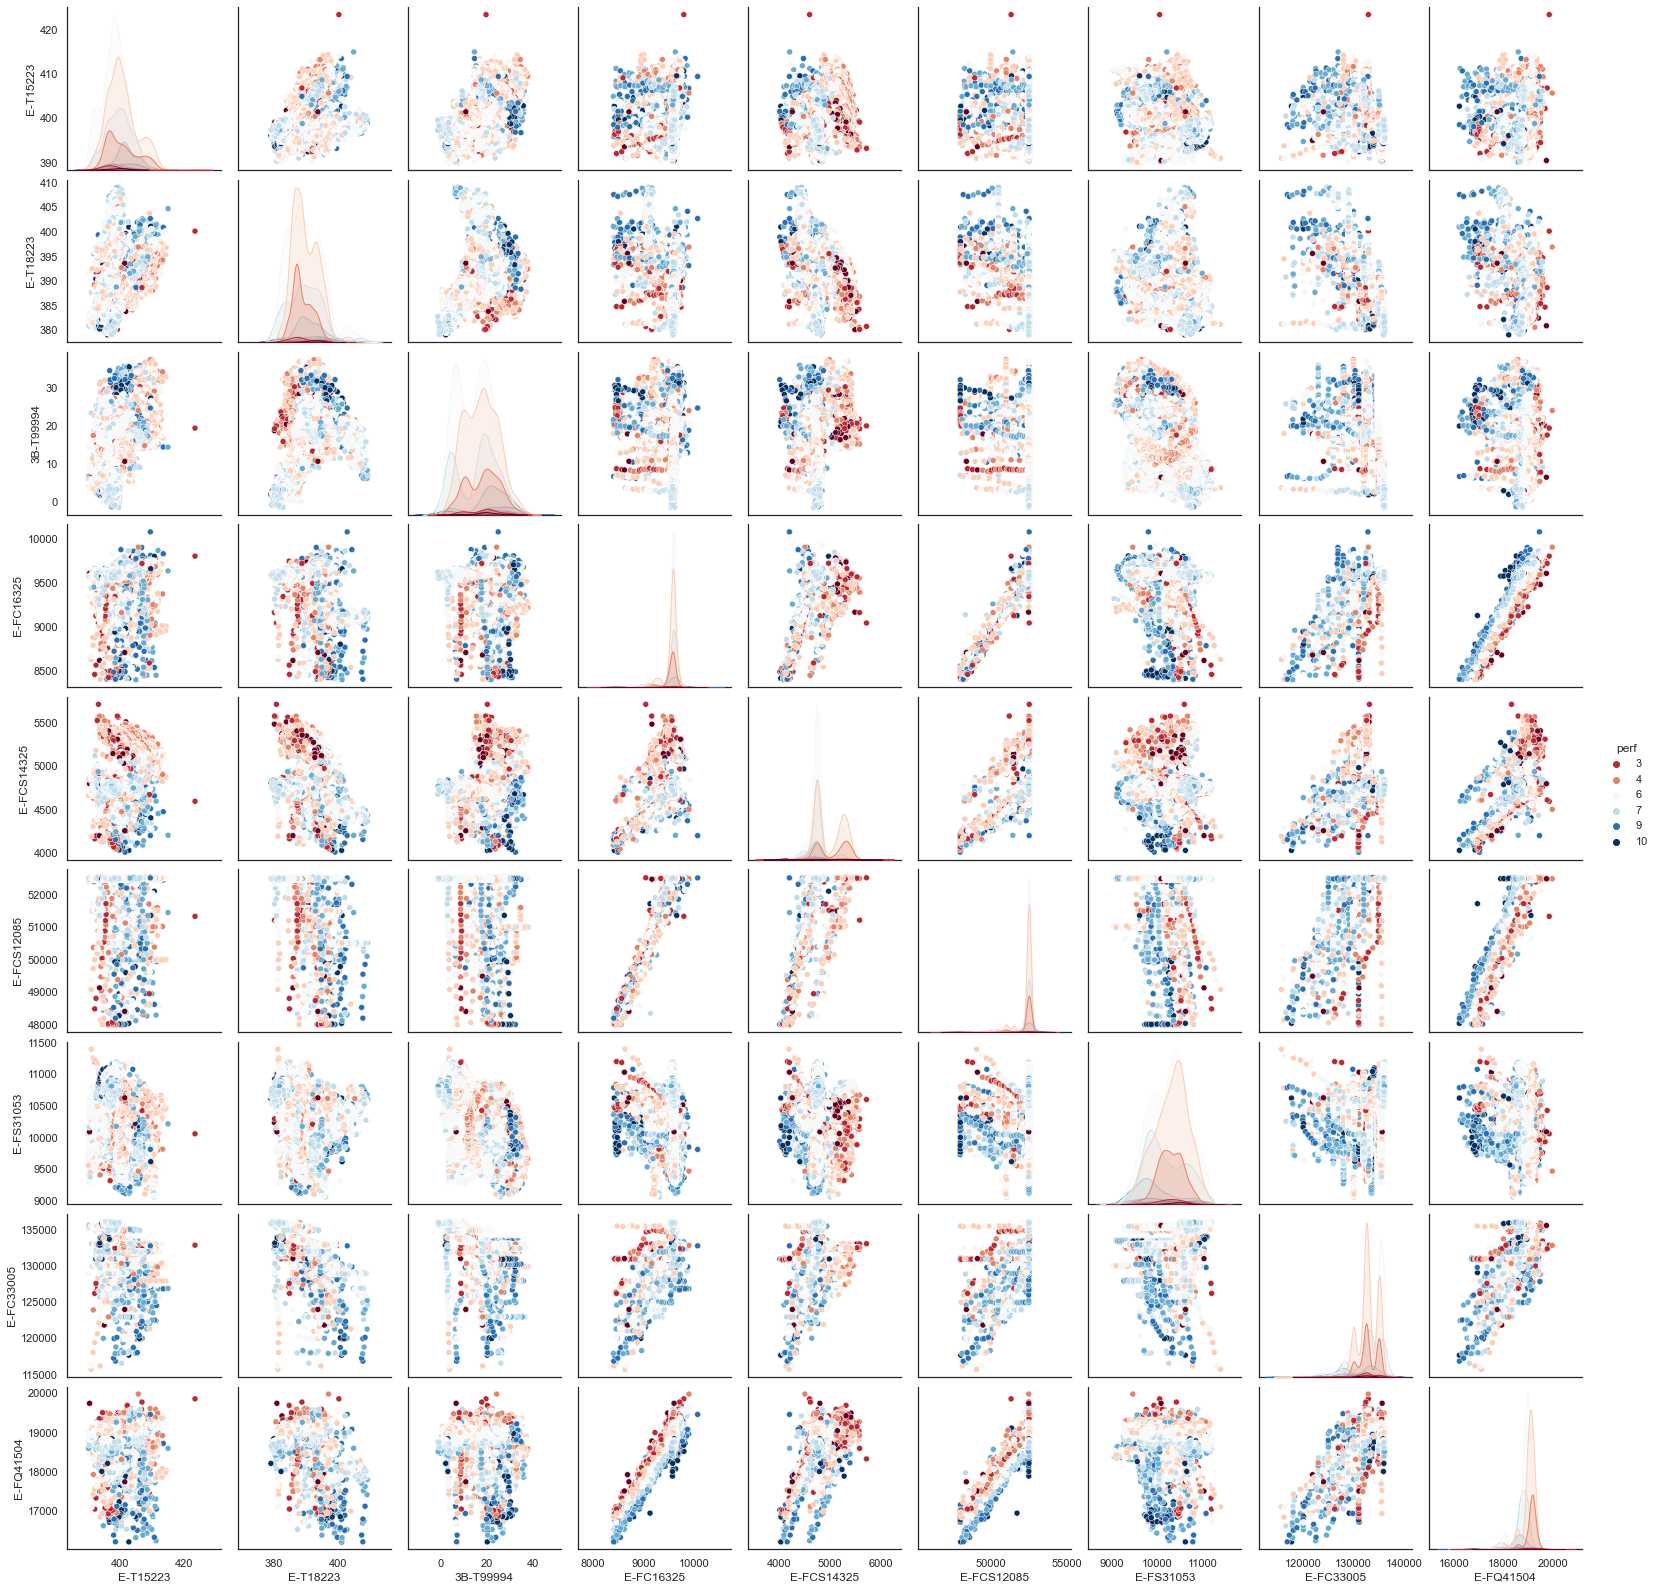

In [37]:
# sns.set_theme(style="ticks")
sns.set_theme(style='white',palette='Blues')
sns.color_palette("tab10")
sns.pairplot(data=result, hue='perf',palette='RdBu') 

# Machine Learning

### On sépare Trainset et Testset
et on vérifie que les deux jeux de données sont bien équilibrés

<AxesSubplot:ylabel='perf'>

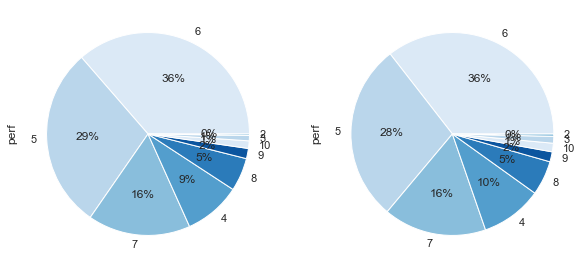

In [17]:
from sklearn.model_selection import train_test_split
trainset, testset = train_test_split(result,test_size=0.8,random_state=0)
plt.figure(figsize=(10,7))
plt.subplot(121)
trainset['perf'].value_counts().plot.pie(autopct='%.0f%%')
plt.subplot(122)
testset['perf'].value_counts().plot.pie(autopct='%.0f%%')

## Preprocessing

In [18]:
def encodage(df):
    return df

In [19]:
def imputation(df):
    df =  df.dropna(axis=0)
    return df

In [20]:
def feature_engineering(df):
    return df

In [21]:
def preprocessing(df):
    df = encodage(df)
    df = feature_engineering(df)
    df = imputation(df)

    X = df.drop('perf',axis=1)
    y = df['perf']

    print(y.value_counts())
    return X,y 

In [22]:
X_train, y_train = preprocessing(trainset)
X_train

6     603
5     474
7     272
4     151
8      88
9      27
10     20
3      14
2       4
Name: perf, dtype: int64


,E-T15223,E-T18223,3B-T99994,E-FC16325,E-FCS14325,E-FCS12085,E-FS31053,E-FC33005,E-FQ41504
timestamp,,,,,,,,,
2021-11-22 18:40:00+00:00,393.01440,385.16060,8.697078,9595.6925,4746.2695,52488.395,10354.4450,135421.80,18893.125
2021-12-16 23:40:00+00:00,398.22190,383.45190,6.960705,9582.1660,4727.1670,52514.015,10856.6100,136062.75,18908.215
2021-11-30 19:20:00+00:00,396.17900,385.90250,5.016641,9557.9235,4717.1485,52502.910,10525.2450,135619.95,19180.875
2021-11-20 07:20:00+00:00,396.48535,387.42870,6.108206,9574.6785,4763.4065,52498.695,10434.6250,135471.40,19064.740
2021-12-01 12:40:00+00:00,393.56285,383.75880,4.634114,9611.5145,4708.7650,52486.935,9727.7135,135515.95,18928.515
...,...,...,...,...,...,...,...,...,...
2021-09-26 14:20:00+00:00,395.93240,390.94895,23.339930,9670.5070,4663.8910,52497.155,9803.6340,132972.60,18869.580
2021-12-16 09:00:00+00:00,396.28920,383.59765,5.307600,9568.1955,4797.5265,52487.545,11025.3700,136009.05,18695.955
2021-10-18 05:20:00+00:00,398.12275,407.64630,6.473397,8727.0660,4342.9445,49553.310,10728.5900,119984.55,16791.715


<AxesSubplot:ylabel='perf'>

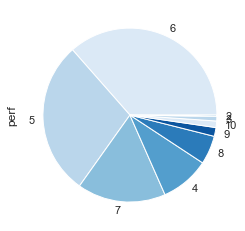

In [23]:
y_train.value_counts().plot.pie()

In [24]:
X_test, y_test = preprocessing(trainset)

6     603
5     474
7     272
4     151
8      88
9      27
10     20
3      14
2       4
Name: perf, dtype: int64


## Model de base et procédure d'évaluation

In [25]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import make_pipeline
from sklearn.feature_selection import SelectKBest,f_classif
from sklearn.preprocessing import PolynomialFeatures
from sklearn.decomposition import PCA

# model = make_pipeline( PolynomialFeatures(2),SelectKBest(f_classif,k=10), RandomForestClassifier(random_state=0))

# model = make_pipeline( SelectKBest(f_classif,k=4), RandomForestClassifier(random_state=0))
model_1 = DecisionTreeClassifier(random_state=0)

In [26]:
from sklearn.metrics import f1_score, confusion_matrix, classification_report
from sklearn.model_selection import learning_curve

In [27]:
def evaluation(model):
    model.fit(X_train,y_train)
    y_pred = model.predict(X_test)

    print(confusion_matrix(y_test,y_pred))
    print(classification_report(y_test,y_pred))

    N, train_score, val_score = learning_curve(model,X_train,y_train,cv=4,train_sizes=np.linspace(0.1,1,10),scoring='f1')
    plt.figure(figsize=(12,8))
    plt.plot(N,train_score.mean(axis=1),c='b')
    plt.plot(N,val_score.mean(axis=1),c='y')

[[  4   0   0   0   0   0   0   0   0]
 [  0  14   0   0   0   0   0   0   0]
 [  0   0 151   0   0   0   0   0   0]
 [  0   0   0 474   0   0   0   0   0]
 [  0   0   0   0 603   0   0   0   0]
 [  0   0   0   0   0 272   0   0   0]
 [  0   0   0   0   0   0  88   0   0]
 [  0   0   0   0   0   0   0  27   0]
 [  0   0   0   0   0   0   0   0  20]]
              precision    recall  f1-score   support

           2       1.00      1.00      1.00         4
           3       1.00      1.00      1.00        14
           4       1.00      1.00      1.00       151
           5       1.00      1.00      1.00       474
           6       1.00      1.00      1.00       603
           7       1.00      1.00      1.00       272
           8       1.00      1.00      1.00        88
           9       1.00      1.00      1.00        27
          10       1.00      1.00      1.00        20

    accuracy                           1.00      1653
   macro avg       1.00      1.00      1.00      165

/Users/rky/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/rky/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/rky/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 216, in __call__
    return self._score(
  File "/Users/rky/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/Users/rky/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py", line 1123, in f1_score
    return fbeta_score(
  File "/Users/rky/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py", line 1261, in fbet

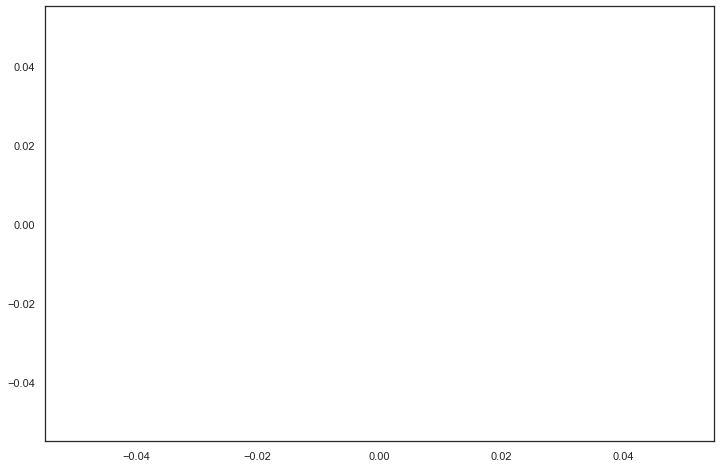

In [28]:
evaluation(model_1)